In [1]:
#This file uses an FFT to invert the Fourier transform of the hypoexponential distribution
import math
import numpy as np
import scipy
import random
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
from scipy import stats

In [35]:
numberOfVars = int(6)        #the number of variables added
fftEvaluationMax = int(1e1)   #the maximum point the characteristic function is sampled at when computing its FFT
fftEvaluations = int(1e3)     #the number of samples of the characteristic function taken

lscale=np.random.exponential(scale=1,size=numberOfVars) #chooses scale parameters
sum_variance=np.sum([2*lscale[i]**(-2) for i in range(numberOfVars)])
fftEvaluationWidth = 2 * fftEvaluationMax / fftEvaluations  
#the width of the sampling of the
#characteristic function of the sum for the purposes of FFT

print("ADDING "+str(numberOfVars)+" VARIABLES")
if(numberOfVars <= 0 or fftEvaluationMax <= 0 or fftEvaluations <= 0):
    print("INVALID INPUT")


ADDING 6 VARIABLES


In [36]:
#takes the product of individual characteristic functions to yield characteristic of the sum
def hypoexponential_fourier_transform(t):
    return np.prod([lscale[i]/(lscale[i]-1.0j*t) for i in range(numberOfVars)])
def bihypoexponential_fourier_transform(t):
    return hypoexponential_fourier_transform(t)*hypoexponential_fourier_transform(-t)
def comparison_gaussian(x):
    return ((math.tau*sum_variance)**(-1/2)*np.exp(-x**2/(2*sum_variance)))
def pure_gaussian(x):
    return math.tau**(-1/2)*np.exp(-x**2)
def fft1(x):
    return np.fft.fft(np.fft.fftshift(x))

In [37]:
def bihypoexponential_fourier_outputs(evalMax, evalWidth):
    return [bihypoexponential_fourier_transform(-evalMax+i*evalWidth) 
            for i in range(round(2*(evalMax/evalWidth)))]

def unrestricted_output_xaxis(evalWidth,evaluations):
    return np.linspace(-1,1,evaluations)

def output_xaxis(evalMax,evaluations):
    return np.linspace(math.floor(-min(evalMax,3*math.sqrt(sum_variance))), math.floor(max(evalMax,3*math.sqrt(sum_variance))),num = math.floor(evaluations))

def bihypoexponential_fourier_outputs_trunc(evalMax, evaluations,evalWidth):
    return [bihypoexponential_fourier_transform(-evalMax+i*evalWidth) 
            for i in range(math.floor(-0.5*len(output_xaxis_trunc(evalMax,evaluations,evalWidth))),math.floor(0.5*len(output_xaxis_trunc(evalMax,evaluations,evalWidth))))]
    

#print(numpy.fft.fft(biexponential_fourier_outputs(fftEvaluationMax, fftEvaluationWidth)))

Area under fourier transform: (6.283185397898856-7.185009904207482e-15j)


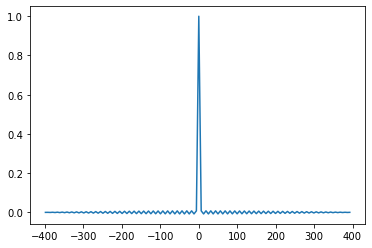

In [48]:
"""
Understand FFT normalization and scale
"""
N = 128
assert np.amax(np.fft.fft(np.ones(N))) == N # This is equiv to sum on phase times amp
assert np.amax(np.fft.ifft(np.ones(N))) == 1 # This is 1/N times sum on phase times amp

def t_from_x(x):
    """
    Get corresponding fourier sample points assuming even spacing
    """
    N = len(x)
    dx = x[1] - x[0]
    t = np.arange(-1 / (2 * dx), 1 / (2 * dx), 1 / (N * dx)) * math.tau
    return(t)

def cont_ft(x, t, f, mode):
    """
    Perform a continuous fourier transform the slow way (for checking answers)
    
    Args:
        x: Sample points in density domain
        t: Sample points in characteristic function domain
        f: Function to transform, evaluated at each of the samples
        mode: Direction of the transform
    """
    if mode == "dens_to_char":
        exp = np.exp(1.0j * np.outer(t, x))
        prefac = 1
        d = x
    elif mode == "char_to_dens":
        exp = np.exp(-1.0j * np.outer(x, t))
        prefac = 1 / math.tau
        d = t
    else:
        raise ValueError(f"'{mode}' is not a valid mode")
    
    integr = prefac * exp * f
    fhat = np.trapz(integr, d, axis=1)
    
    return(fhat)

x = np.linspace(-0.5, 0.5, num=N)
t = t_from_x(x)
f = np.ones(N)

fhat = cont_ft(x, t, f, "dens_to_char")

plt.plot(t, np.real(fhat))
print(f"Area under fourier transform: {np.trapz(fhat, t)}") # Should be approx tau

Check that it recovers a Gaussian

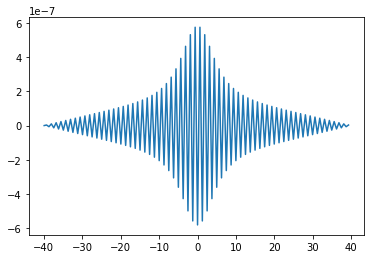

In [63]:
x = np.linspace(-5, 5, num=128)
t = t_from_x(x)
f = stats.norm.pdf(x)
fhat = cont_ft(x, t, f, "dens_to_char")

plt.plot(t, np.real(fhat) - stats.norm.pdf(t) * np.sqrt(math.tau)) # Should have small oscillations due to the clipped domain

### Oscillations are undesirable if we want accurate confidence estimates, but may be unavoidable in a discrete setting. The next couple cells try an FFT implementation

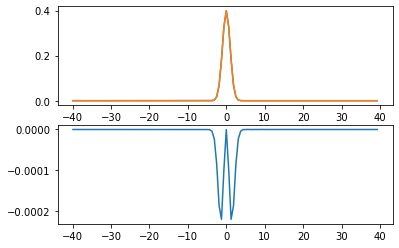

In [3]:
def fft_cont(t, fhat):
    """
    Only go from characteristic function to density. Assumes middle of t is 0.
    """
    N = len(t)
    fhat_shift = np.fft.fftshift(fhat)
    tfreq = t / math.tau # FFT assumes 2pi in exponent
    dtfreq = tfreq[1] - tfreq[0]
    x_shift = np.fft.fftfreq(N, dtfreq)
    
    x = np.fft.fftshift(x_shift)
    f_shift = np.fft.fft(fhat_shift) * dtfreq
    f = np.fft.fftshift(f_shift)
    
    return(x, f)

t = np.linspace(-5, 5, num=128)
fhat = stats.norm.pdf(t) * np.sqrt(math.tau)

x, f = fft_cont(t, fhat)

fig, ax = plt.subplots(nrows=2)
ax[0].plot(x, np.array([np.real(f), stats.norm.pdf(x)]).T) # Nearly exact overlap, bottom shows residual
ax[1].plot(x, np.real(f) - stats.norm.pdf(x)) # Some weird small shit going on near the origin but otherwise looks good

### Test on bihyp exp

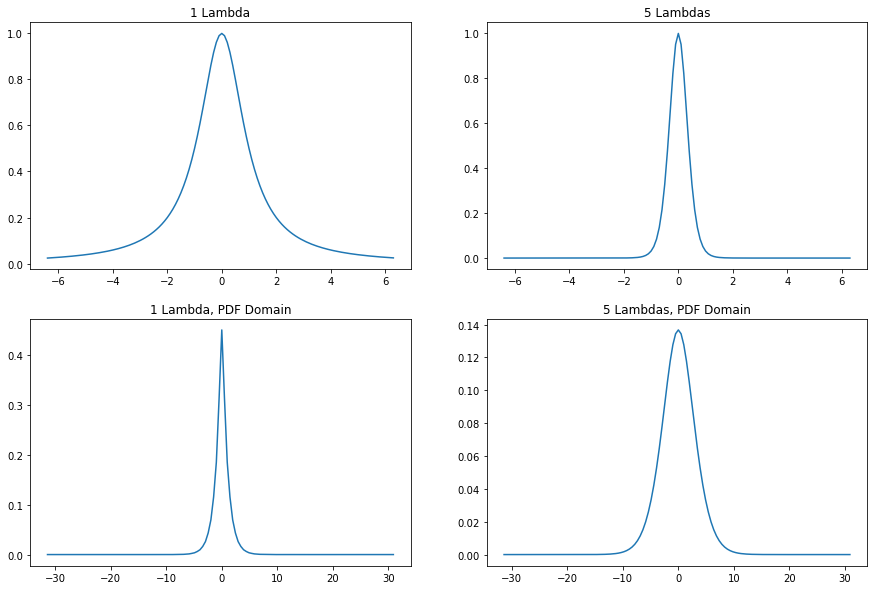

In [14]:
def bihyp_exp_cf(t, lams, norm='sum'):
    N = len(lams)
    if norm == 'sum':
        lams = 1 * lams # Do not touch the lambdas
    elif norm == "avg":
        lams = N * lams
    elif norm == "z-score":
        lams = np.sqrt(N) * lams
    else:
        raise ValueError("Only valid norms are 'sum', 'avg', and 'z-score'.")
    cf = np.prod([1 / (1 + t**2 / lam**2) for lam in lams], axis=0)
    return(cf)

def four_panel_comp(norm='sum'):

    t = np.arange(-6.4, 6.4, 0.1)
    lams = np.ones(1)
    fhat = bihyp_exp_cf(t, lams, norm=norm)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    ax[0, 0].plot(t, fhat)
    ax[0, 0].set_title("1 Lambda")
    x, f = fft_cont(t, fhat)
    ax[1, 0].plot(x, np.real(f))
    ax[1, 0].set_title("1 Lambda, PDF Domain")

    lams = np.ones(5)
    fhat = bihyp_exp_cf(t, lams, norm=norm)
    ax[0, 1].plot(t, fhat)
    ax[0, 1].set_title("5 Lambdas")
    x, f = fft_cont(t, fhat)
    ax[1, 1].plot(x, np.real(f))
    ax[1, 1].set_title("5 Lambdas, PDF Domain")
    
    return None

four_panel_comp()

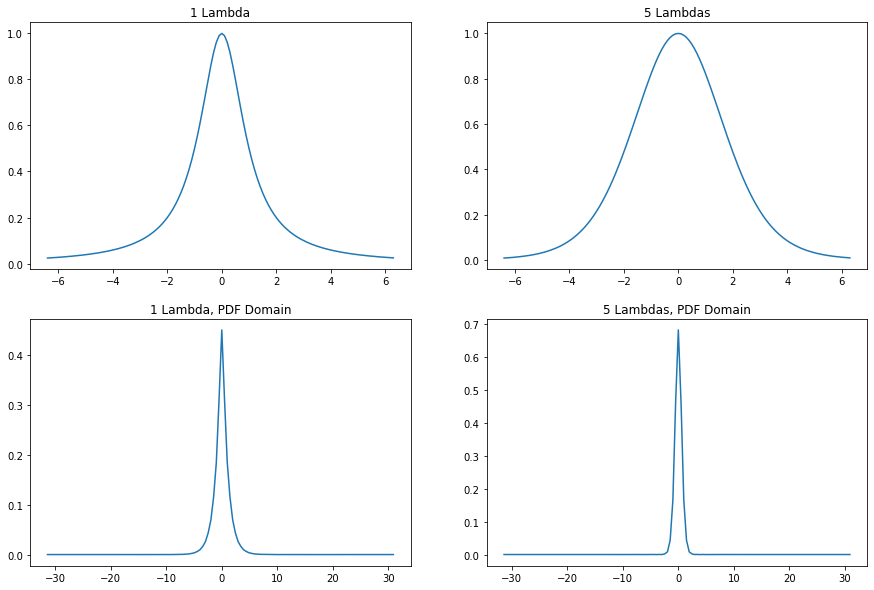

In [15]:
four_panel_comp(norm='avg')

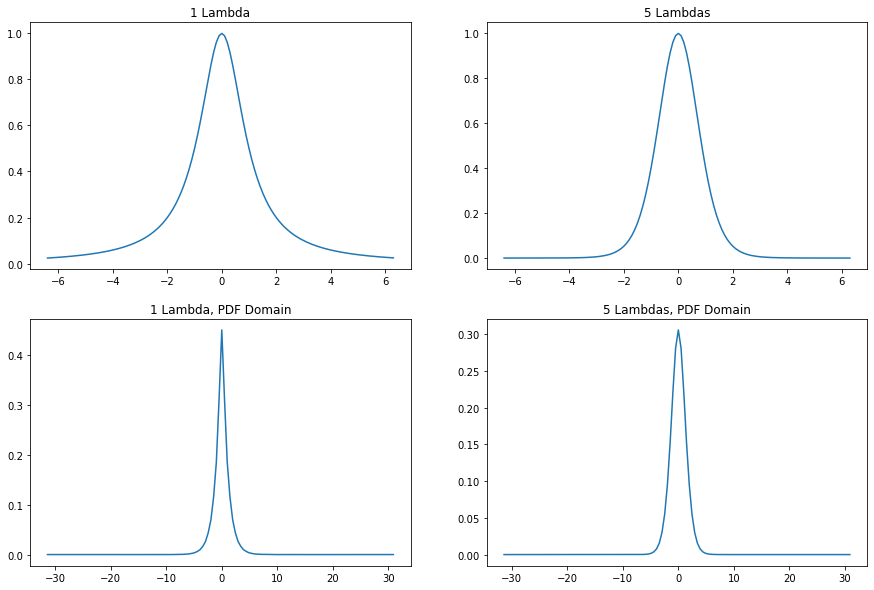

In [16]:
four_panel_comp(norm='z-score')

0.01


/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


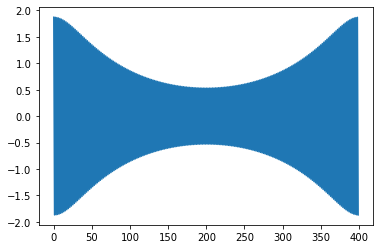

In [51]:
print(1e-2)
plt.plot(np.fft.fft(bihypoexponential_fourier_outputs(2,1e-2)))

/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


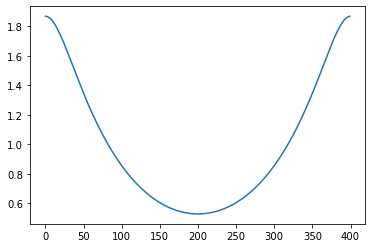

In [52]:
plt.plot(np.fft.fft(np.fft.fftshift(bihypoexponential_fourier_outputs(2,1e-2))))

/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


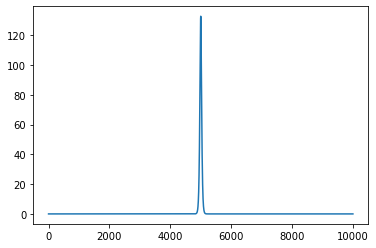

In [7]:
plt.plot(np.fft.fftshift(np.fft.fft(np.fft.fftshift(bihypoexponential_fourier_outputs(fftEvaluationMax,fftEvaluationWidth)))))

/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


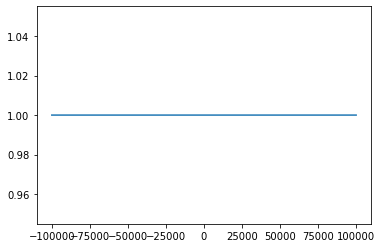

In [19]:
plt.plot(output_xaxis(fftEvaluationMax,fftEvaluations,fftEvaluationWidth)/math.sqrt(sum_variance), np.fft.fftshift(np.fft.fft(np.fft.fftshift(bihypoexponential_fourier_outputs(fftEvaluationMax,fftEvaluationWidth)))))

In [39]:
print(output_xaxis(fftEvaluationMax,fftEvaluations)[:10])

[-140.         -138.99858999 -137.99717997 -136.99576996 -135.99435994
 -134.99294993 -133.99153992 -132.9901299  -131.98871989 -130.98730987]


In [39]:
print(sum_variance)

46.89093941706658


In [41]:
print(output_xaxis(fftEvaluationMax,fftEvaluations)[:10]/math.sqrt(sum_variance))

[-3.00062734 -2.97916407 -2.9577008  -2.93623752 -2.91477425 -2.89331098
 -2.8718477  -2.85038443 -2.82892116 -2.80745788]


In [38]:
outputs = np.fft.fftshift(np.fft.fft(np.fft.fftshift(bihypoexponential_fourier_outputs(fftEvaluationMax,fftEvaluationWidth))))
print(outputs[:10])

[-5.09260602e-15-4.40290602e-17j  4.34401863e-15-1.36856019e-16j
 -4.89126968e-15-8.97420120e-16j  3.41805577e-15-4.51159320e-16j
 -5.12285526e-15-1.63992083e-16j  4.97497009e-15-2.14663680e-16j
 -4.98602895e-15-6.79301197e-16j  3.66330230e-15-4.79269167e-16j
 -5.14692455e-15-5.54233870e-16j  4.75400969e-15+2.22312871e-16j]


In [44]:
print(len(outputs))

100000


In [40]:
print(outputs[49950:50050])

[]


/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


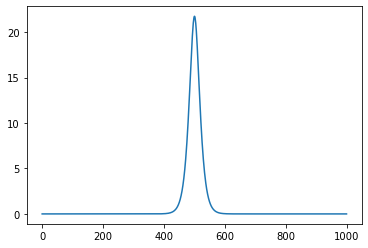

In [42]:
plt.plot(outputs)

/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


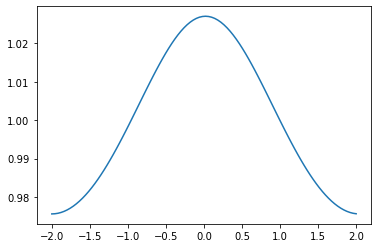

In [58]:
plt.plot(unrestricted_output_xaxis(fftEvaluationMax,fftEvaluations),np.fft.fftshift(np.fft.fft(np.fft.fftshift(bihypoexponential_fourier_outputs(fftEvaluationMax,fftEvaluationWidth)))))

In [53]:
outputs2 = np.multiply(np.fft.fftshift(np.fft.fft(np.fft.fftshift(bihypoexponential_fourier_outputs(fftEvaluationMax,fftEvaluationWidth)))),fftEvaluationWidth)

In [89]:
#plt.plot(unrestricted_output_xaxis(fftEvaluationMax,fftEvaluations),outputs2-1)

gaussianoutputs=[]
for i in range(len(unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations))):
    gaussianoutputs.append(comparison_gaussian(unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations)[i]))
    

#plt.plot(unrestricted_output_xaxis(fftEvaluationMax,fftEvaluations),gaussianoutputs)

In [3]:
a = [ 1,2,3]
a.append(4)
print(a)
print(a*3)
print(3*a)
print(np.power(a,[2,2,2,2]))
print(np.ones(4))

[1, 2, 3, 4]
[1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]
[1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]
[ 1  4  9 16]
[1. 1. 1. 1.]


/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


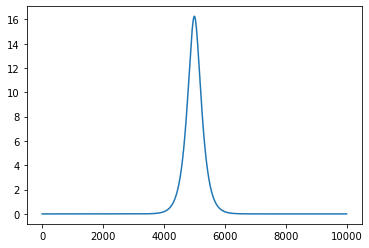

In [51]:
plt.plot(np.fft.fftshift(np.fft.fft(np.fft.fftshift(bihypoexponential_fourier_outputs(fftEvaluationMax,fftEvaluationWidth)))))

/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


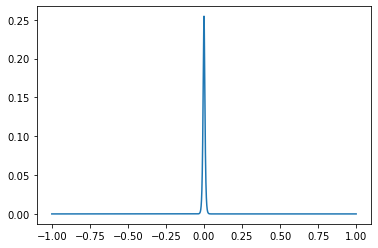

In [115]:
#plt.xlim((-3,3))
plt.plot(unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations),outputs2)
#plt.plot(unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations),comp_gauss_array2)
#plt.plot(unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations),gaussianoutputs)

In [10]:
print(sum_variance)

123.78376558350976


In [27]:
print(lscale)

[1.10540517 0.23672826 1.38364559 0.61323251 0.37748081 0.04056269
 0.78970471 1.66549811 0.90537509 0.09810155 0.17203844 4.00080311
 0.40836623 6.10002302 1.46869121 1.05371547 0.36242556]


In [29]:
print(2*0.098**(-2))

208.2465639316951


In [35]:
print(1/fftEvaluationWidth)

500.0


In [87]:
print(np.sum(outputs2))

(9999.999999999998+3.2311742677852644e-27j)


In [39]:
print(np.var(outputs2))

23.84461499217335


In [40]:
(23.8/20)**2

1.4161

In [107]:
test_var=max(outputs2)**(-2)/math.tau
def comp_gauss_2(x):
    return (math.tau*test_var)**(-0.5)*np.exp(-0.5*x**2/test_var)
comp_gauss_array2=[]
for i in range(fftEvaluations):
    comp_gauss_array2.append(comp_gauss_2((unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations)[i])))
print(len(comp_gauss_array2))

10000


In [111]:
print(max(outputs2)**(-2)/math.tau)
print(sum_variance)

(0.0006020449211085417+0j)
135.7717564369972


In [112]:
print(sum_variance/max(outputs2)**(-2)/math.tau)

(5712.428834241259+0j)


In [113]:
print(1/fftEvaluationWidth)

500.0


In [73]:
print(np.sum(outputs))

(1000+0j)


In [13]:
print(np.var(outputs))

85.27919181057622


In [14]:
print(len(outputs))

10000


In [15]:
print(sum_variance/np.var(outputs))

1.451511945123268


In [16]:
print(fftEvaluationWidth)

0.002


In [45]:
print(max(outputs))

(21.755357414455723+0j)


In [18]:
print(outputs[5000])

(132.69796292857257+0j)


/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


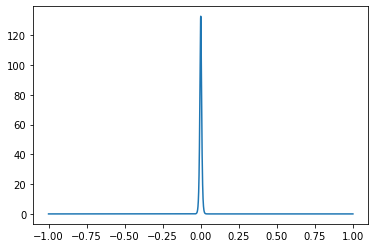

In [19]:
plt.plot(unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations),outputs)

In [48]:
#calculate the variance as obtained through FFT
fft_var = np.sum(np.multiply(np.power(unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations),2),outputs))

In [30]:
print(sum_variance/fft_var)
print(math.sqrt(sum_variance/fft_var))

(246.64160101865275-4.2637134698635305e-11j)
15.70482731578583
19.739208802178716


/var/folders/gj/__b576yx281fswz42qs0_sjm0000gn/T/ipykernel_4077/3256844612.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  print(math.sqrt(sum_variance/fft_var))


In [31]:
outputs2 = np.multiply(outputs,fftEvaluationWidth)

/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


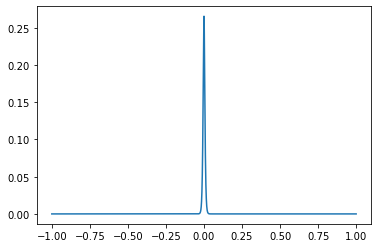

In [32]:
plt.plot(unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations),outputs2)

In [34]:
print((sum_variance*math.tau)**(-0.5))

0.03585735251394608


In [52]:
print(max(outputs)/(sum_variance*math.tau)**(-0.5))

(373.42262159329937+0j)


/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


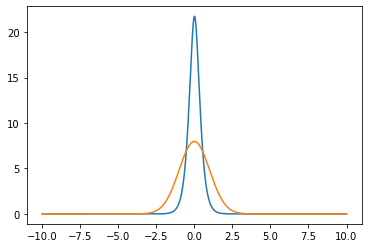

In [72]:
xaxis4 = np.linspace(-fftEvaluationMax,fftEvaluationMax,fftEvaluations)
plt.plot(xaxis4,outputs)
def comparison_gaussian_1(x):
    return ((math.tau)**(-1/2)*np.exp(-x**2/(2)))
#sn_pdf = scipy.stats.norm.pdf(xaxis4)
plt.plot(xaxis4,20*comparison_gaussian_1(xaxis4))

In [49]:
print(fft_var)

(1.9052267417918527-4.343104203054419e-15j)


In [50]:
fft_var2 = np.sum(np.multiply(np.power(np.linspace(-fftEvaluationMax,fftEvaluationMax,fftEvaluations),2),outputs))
print(fft_var2)

(190.52267417918512-4.3431042030546713e-13j)


In [51]:
print(4*sum_variance)

187.56375766826633


/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


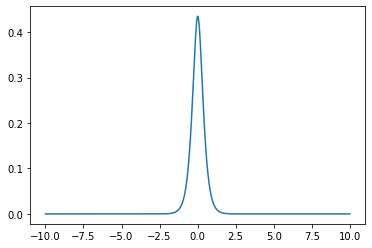

In [54]:
plt.plot(np.linspace(-fftEvaluationMax,fftEvaluationMax,fftEvaluations),outputs2)

In [57]:
bscale=[]
bscale_squares=[]
for i in range(numberOfVars): 
    bscale.append(1/lscale[i])
    bscale_squares.append(bscale[i]**2)
#these are the induced betas
    
pt_mean = np.sum(bscale)
pt_var = np.sum(bscale_squares)
#compute the mean and variance of the sum distribution

theta = np.zeros((numberOfVars,numberOfVars))
#initialize theta

for i in range(numberOfVars):
    theta[i,i]=-lscale[i]
    if(i<numberOfVars-1):
        theta[i,i+1]=lscale[i]
#defines the rate matrix
print(theta)


def projected_pdf(x):
    if(x>=0):
        return (-(np.sum(np.einsum('ij,jk',scipy.linalg.expm(x*theta),theta),axis=1)[0]))
    else:
        return 0

#the cdf and pdf in the matrix-exponential formulation


#another check

#now we just produce the graph

biexponential_outputs=[]

def projected_biexponential_pdf(x):
    result=integrate.quad(lambda y:projected_pdf(y)*projected_pdf(y-x),-20,20)    
    return(result[0])

[[-3.30016117  3.30016117  0.          0.          0.          0.        ]
 [ 0.         -2.12786946  2.12786946  0.          0.          0.        ]
 [ 0.          0.         -0.46629226  0.46629226  0.          0.        ]
 [ 0.          0.          0.         -0.6170008   0.6170008   0.        ]
 [ 0.          0.          0.          0.         -0.25508186  0.25508186]
 [ 0.          0.          0.          0.          0.         -1.3634309 ]]


hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!


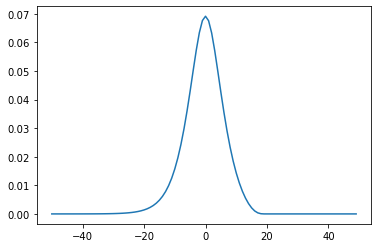

In [58]:
inputs=[]

pdf_outputs=[]

for i in range(100):
    inputs.append((-50+i))

    pdf_outputs.append(projected_pdf(inputs[i]))
    biexponential_outputs.append(projected_biexponential_pdf(inputs[i]))
    print("hi!")

#plt.plot(inputs,pdf_outputs)
plt.plot(inputs,biexponential_outputs)

In [59]:
print(projected_biexponential_pdf(0))

0.06910669586859539


/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


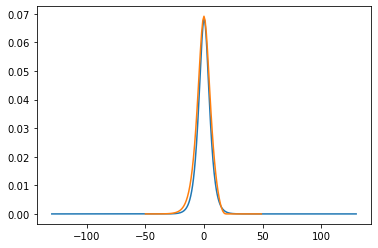

In [69]:
plt.plot(np.linspace(-13*fftEvaluationMax,13*fftEvaluationMax,fftEvaluations),outputs/320)
plt.plot(inputs,biexponential_outputs)

# Mike's Additions

NameError: name 'np' is not defined